<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/Area_Restricted_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Seabird Diving Behaviour with GPS data

First Time Passage



## Loading Drive

In [25]:
# # mount google drive
# from google.colab import drive
# drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [26]:
# %cd drive/My\ Drive/BirdDL

[Errno 2] No such file or directory: 'drive/My Drive/BirdDL'
/content/drive/My Drive/BirdDL


## Data Formatting

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
import datetime
import random
import pickle

import trip

In [2]:
# connect to database
# conn = sqlite3.connect('/content/drive/My Drive/data/seabirdbank.db')
conn = sqlite3.connect('/home/amdroy/MEGA/DATA/seabirdbank.db')

In [3]:
request = "SELECT DISTINCT lon, lat FROM fieldwork WHERE place='Pescadores'"
colony = pd.read_sql_query(request, conn)
colony = colony.values
colony

array([[-77.264, -11.773]])

In [4]:
request = "SELECT \
            trip.id as trip, gps.datetime, gps.lon, gps.lat\
            FROM gps \
            INNER JOIN trip ON gps.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# substr(bird.fieldwork,1,1) = 'P'

gps = pd.read_sql_query(request, conn)
gps

,trip,datetime,lon,lat
0,P1108_4_SV_T1,2008-11-25 13:00:35,-77.264128,-11.773317
1,P1108_4_SV_T1,2008-11-25 13:00:36,-77.264118,-11.773235
2,P1108_4_SV_T1,2008-11-25 13:00:37,-77.264098,-11.773152
3,P1108_4_SV_T1,2008-11-25 13:00:38,-77.264113,-11.773060
4,P1108_4_SV_T1,2008-11-25 13:00:39,-77.264142,-11.772955
...,...,...,...,...
839803,P1113_50_SV_T2,2013-11-25 05:23:26,-77.264832,-11.773701
839804,P1113_50_SV_T2,2013-11-25 05:23:27,-77.264862,-11.773664
839805,P1113_50_SV_T2,2013-11-25 05:23:28,-77.264900,-11.773705
839806,P1113_50_SV_T2,2013-11-25 05:23:29,-77.264931,-11.773739


In [5]:
# check duplicated datetime in GPS trip
idx = gps.index[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]
idx_drop = [idx[i] for i in range(0, len(idx), 2)]
gps = gps.drop(idx_drop)

In [6]:
gps[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]

,trip,datetime,lon,lat


In [7]:
request = "SELECT \
            trip.id as trip, tdr.datetime, tdr.pressure \
            FROM tdr \
            INNER JOIN trip ON tdr.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# WHERE substr(bird.fieldwork,1,1) = 'P' 

tdr = pd.read_sql_query(request, conn)
tdr

,trip,datetime,pressure
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29
...,...,...,...
1086337,P1113_50_SV_T2,2013-11-25 05:23:26,-0.94
1086338,P1113_50_SV_T2,2013-11-25 05:23:27,-0.94
1086339,P1113_50_SV_T2,2013-11-25 05:23:28,-0.94
1086340,P1113_50_SV_T2,2013-11-25 05:23:29,-0.94


In [8]:
tdr['datetime'] = pd.to_datetime(tdr['datetime'], format='%Y-%m-%d %H:%M:%S')
gps['datetime'] = pd.to_datetime(gps['datetime'], format='%Y-%m-%d %H:%M:%S')

In [9]:
df = pd.merge(tdr, gps, on=['trip', 'datetime'], how='left')
df

,trip,datetime,pressure,lon,lat
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955
...,...,...,...,...,...
1086337,P1113_50_SV_T2,2013-11-25 05:23:26,-0.94,-77.264832,-11.773701
1086338,P1113_50_SV_T2,2013-11-25 05:23:27,-0.94,-77.264862,-11.773664
1086339,P1113_50_SV_T2,2013-11-25 05:23:28,-0.94,-77.264900,-11.773705
1086340,P1113_50_SV_T2,2013-11-25 05:23:29,-0.94,-77.264931,-11.773739


In [10]:
# check NaN and fill with interpolations
[i for i, x in enumerate(df['lon'].isna()) if x]


df['lon'] = df['lon'].interpolate(method='polynomial', order=2)
df['lat'] = df['lat'].interpolate(method='polynomial', order=2)

In [11]:
len(df.trip.unique())

185

In [12]:
bad_trip = ['P1111_9_SV_T1', 'P1111_13_SV_T6', 'P1111_41_SV_T2', 'P1111_46_SV_T5', 'P1111_52_SV_T1',
            'P1112_4_SV_T2', 'P1112_26_SV_T5', 'P1112_36_SV_T1', 'P1112_36_SV_T2', 'P1113_41_SV_T3',
           'P1113_50_SV_T2']

no_loop = ['P1112_26_SV_T1', 'P1112_26_SV_T2', 'P1112_26_SV_T3', 'P1112_26_SV_T4']

In [13]:
### remove bad data
idx = df.index[[(t in bad_trip or t in no_loop) for t in df.trip]]
df = df.drop(idx)

In [14]:
len(df.trip.unique())

170

## Area Restricted Search

### Example

In [15]:
%%time

df_trip = df[df.trip == 'P1108_4_SV_T1']

t = trip.Trip(df_trip)
t.compute_dist_matrix()

Distance [6626/6627]
CPU times: user 59.5 s, sys: 1.98 s, total: 1min 1s
Wall time: 56.3 s


In [16]:
radius=250
residence = t.residence_time(radius)
first_passage = t.first_time_passage(radius)

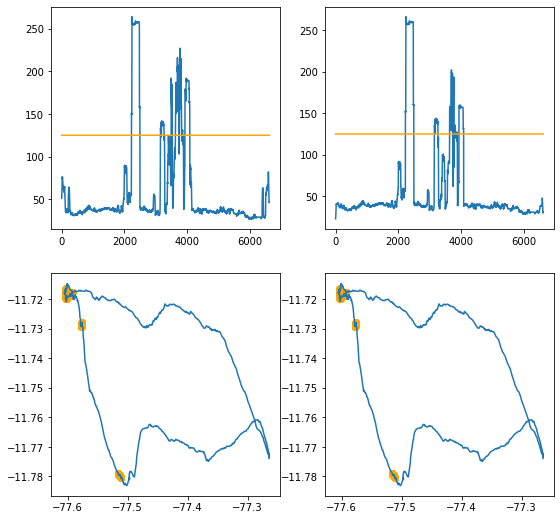

In [17]:
tt = 125
dive_ars = np.array(first_passage)>tt

plt.figure(figsize=(9, 9))

plt.subplot(2, 2, 1)
plt.plot(residence)
plt.plot(tt*np.ones(len(residence)), c = 'orange')

plt.subplot(2, 2, 2)
plt.plot(first_passage)
plt.plot(tt*np.ones(len(residence)), c = 'orange')

plt.subplot(2, 2, 3)
plt.plot(t.df.lon.values, t.df.lat.values)
plt.scatter(t.df.lon.values[dive_ars], \
            t.df.lat.values[dive_ars], c = 'orange')

plt.subplot(2, 2, 4)
plt.plot(t.df.lon.values, t.df.lat.values)
plt.scatter(t.df.lon.values[dive_ars], \
            t.df.lat.values[dive_ars], c = 'orange')

In [21]:
# compute prediction
threshold = 1
t.add_dive(threshold)

# overall performance
true = np.sum(t.df.dive == dive_ars)/len(t.df)

# no dive prediction performance
no_dive_prediction = [dive_ars[i] for i in range(len(t.df)) if not t.df.dive[i]]
true_no_dive = 1-np.sum(no_dive_prediction)/len(no_dive_prediction)

# dive prediction performance
dive_prediction = [dive_ars[i] for i in range(len(t.df)) if t.df.dive[i]]
true_dive = np.sum(dive_prediction)/len(dive_prediction)

In [22]:
true

0.8877320054323223

In [23]:
(true_no_dive + true_dive)/2

0.5779038112522686

### All trajectories

In [ ]:
for k in df.trip.unique():
    df_trip = df[df.trip == k]

    t = trip.Trip(df_trip)
    t.compute_dist_matrix()
    
    filepath = '/home/amdroy/MEGA/DATA/DISTANCE/' + k + '.pkl'

    with open(filepath, 'wb') as save_file:
        pickle.dump(t.dist_matrix, save_file, -1)

Distance [50070/51865]
